- Learn PyTorch: https://www.learnpytorch.io/01_pytorch_workflow/
- PyTorch Documentation: https://pytorch.org/

### Points to be covered
- Data prepare and load
- Build model
- fitting the model to data
- making prediction and evaluating a model
- saving and laod model
- putting it all together

In [1]:
import torch
from torch import nn # nn contains all the building block for neural networks
import matplotlib.pyplot as plt

# checking PyTorch version
print(torch.__version__)

2.1.0+cu121


## 1. Data Preparing and loading

Data can be almost anything..... in machine learning
- Excel spreadsheet
- Images
- Video
- Audio
- DNA
- Text

Machine learning is a game of two parts:
- Get data into a numerical representation.
- Build a model to learn patterns in that numerical representation.

We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

### Splitting data into test and train dataset

In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

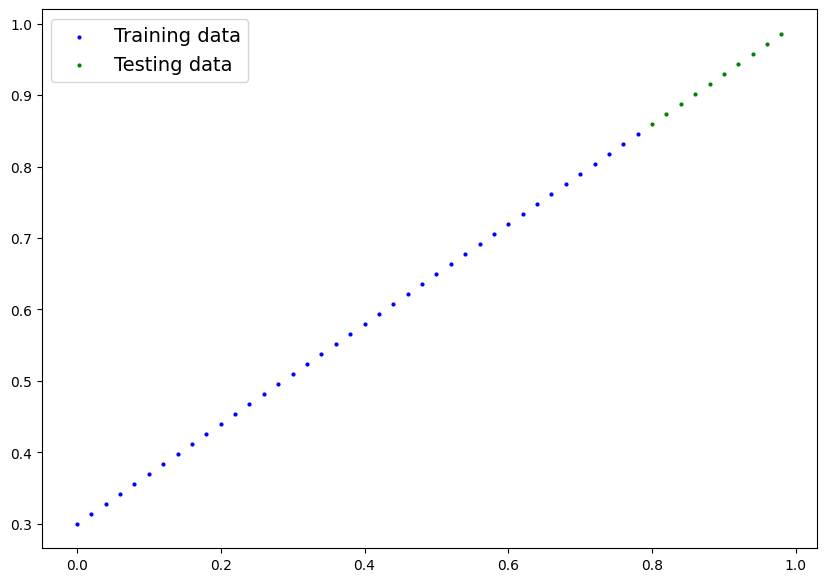

In [6]:
plot_predictions()

## 2. Build Model

In [7]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): #nn.Module: Base class for all Neural Netwrok modules
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1,   # <- start with a random weight and try to adjust it to ideal weight
                                        requires_grad=True, # <- can this parameter be updated via gradient descent?
                                        dtype= torch.float)) # <- datatype torch.float32

    self.bias = nn.Parameter(torch.randn(1,   # <- start with a random weight and try to adjust it to ideal weight
                                        requires_grad=True, # <- can this parameter be updated via gradient descent?
                                        dtype= torch.float)) # <- datatype torch.float32

  # Forward(): Any subclass of nn.Module needs to override forward(). this defines the forward computation of the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weight * x + self.bias



### PyTorch model buildign essentials

- `torch.nn`: Contains all of the building blocks for computational graphs essentially a series of computations executed in a particular way).
- `torch.nn.Parameter`:Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".
- `torch.nn.Module`: The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.
- `torch.optim`: Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).
- `def forward()`: All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).
- `torch.utils.data.Dataset`: Represents a map between key(label) and sample(features) pairs of your data. Such as images and their associated labels.
- `torch.utils.data.DataLoader`: Creates a Python iterable over a torch Dataset(allows you to iterate over your data).

### Checking the contents of a PyTorch model
Now we've got these out of the way, let's create a model instance with the class we've made and check its parameters using `.parameters()`.

In [8]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`
when we pass data through our model, it's going to run it through the `forward()` method.


In [10]:
# make prediction with model

with torch.inference_mode(): # inference_mode(): It
  y_preds = model_0(y_test)

y_preds

tensor([[0.4184],
        [0.4231],
        [0.4278],
        [0.4325],
        [0.4372],
        [0.4419],
        [0.4466],
        [0.4514],
        [0.4561],
        [0.4608]])

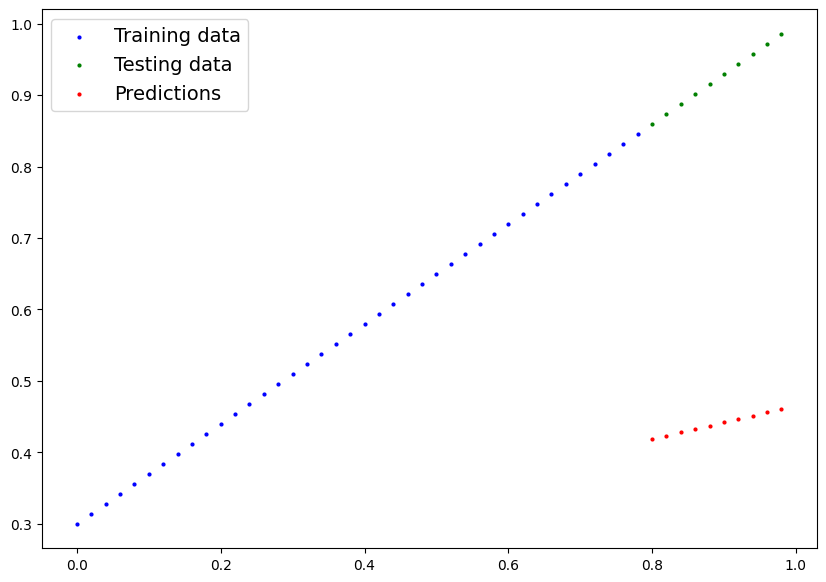

In [11]:
plot_predictions(predictions=y_preds)

## 3. Train Model

**Loss Function**: A function to measure how wwrong your model's predictions are to the ideal outputs, lower is better

In [12]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
#  setup a loss functions
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # we want to optimize the parameters present in our model
                            lr=0.001)

### Building a training and testing loop in PyTorch

1. Forward pass:	The model goes through all of the training data once, performing its forward() function calculations.	`model(x_train)`
2.	Calculate the loss:	The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.	`loss = loss_fn(y_pred, y_train)`
3. Zero gradients: The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step.	`optimizer.zero_grad()`
4.	Perform backpropagation on the loss:	Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards".	`loss.backward()`
5.	Update the optimizer (gradient descent):	Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them.	`optimizer.step()`

In [ ]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 1000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model): it turn on gradient mode
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode, and turn off different settings in the model not needed for evaluation/testing (Dropout, batch norm...)
    model_0.eval()

    with torch.inference_mode(): # turn off gradient tracking
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

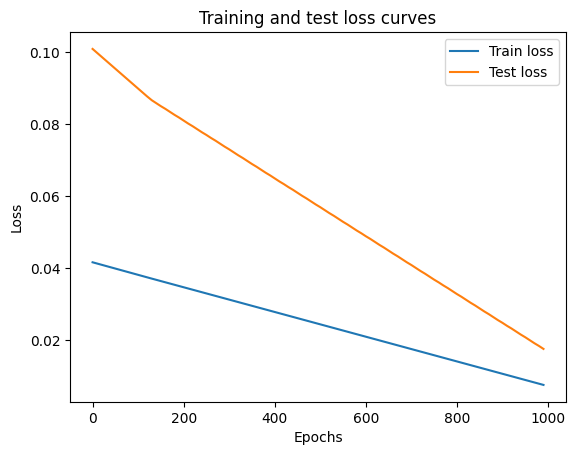

In [22]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## Saving a model in PyTorch :

https://pytorch.org/tutorials/beginner/saving_loading_models.html

There are three main methods one should about for saving and loading models in PyTorch

1. `torch.save()`: allows to save a PyTorch object in Pytthon's pickle formate
2. `torch.load()`: allows to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()`: this allows to load a model's saved state dictionary

In [26]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

Since we saved our model's `state_dict()` rather then entire model, we will create a new instance of our model class and load the saved `state_dict()` into that.

In [27]:
# Create a instance
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [28]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6642])), ('bias', tensor([0.3150]))])

In [29]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model